In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression

# statsmodels and sklearn are currently not used. Both packages can be omitted for now, but sklearn will
# very likely be used in the future

%matplotlib inline

# Folder containing the data file
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on desktop
data_dir = r'C:\Users\cah4016\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\Preeclampsia Model\RTG11\QUS_Processing_Andrew' # on laptop
data_dir = r'F:\OneDrive - med.cornell.edu\Documents\Photoacoustic_Placenta\IUS_2023' # For IUS 2023 abstract
data_dir = r'C:\Users\andre\Box\WCM_Tulane_Shared_Folder\Preeclampsia Model' # For UITC 2023 talk

# Name of the file containing the QUS results
data_fid = r'2023-03-07_GD14-18.csv'
data_fid = r'2023-05-24.csv'

# Move to the data folder and read the .csv into a DataFrame
os.chdir(data_dir)
in_data = pd.read_csv(data_fid)

# Rename the columns using abbreviations for the parameter names
new_names = {'HK Structure Param':'HK k','HK Scatterer Clustering Param':'HK alpha','Nak Shape Param':'Naka m','Nak Scale Factor':'Naka Omega', 
             'Spectral Slope':'SS','Intercept':'I0','Midband Fit':'MBF','Effective Scatterer Size':'ESD','Acoustic Concentration':'EAC'}
in_data.rename(new_names,axis=1,inplace=True)

# Convert ESD from m to um
in_data['ESD'] *= 1e6

# Remove any rows where the ESD is zero 
# This means QUS estimation failed
remove_idx = (in_data['ESD'] <= 0)
in_data.drop(in_data.loc[remove_idx].index,inplace=True)

# Log compress the Nakagami Omega and HK alpha parameters
in_data['Naka Omega'] = np.log10(in_data['Naka Omega'])
in_data['HK alpha'] = np.log10(in_data['HK alpha'])

# As a precaution, remove any rows that contain a NaN in any column
in_data.dropna(axis=0,inplace=True)

# Based on the ID string, split into new columns with ID, Day, and Frame #
in_data[['ID','Day','Frame']] = in_data['ID'].str.split('_',2,expand=True)

# Convert Day column into integer data type (instead of string)
in_data['Day'] = in_data['Day'].astype(int)

# The .csv contains a row for every ROI within the placenta boundaries in each frame.
# Compute the mean of the QUS parameters within each placenta
mean_data = in_data.groupby(['ID','Day'],as_index=False).mean()

# All QUS parameters - this list will make life easier later
qus_params = ['ESD','EAC','MBF','SS','I0','Naka Omega','Naka m','HK k','HK alpha','ROI Z Dist']

In [2]:
# Compute the independent samples t-test between placentas on days 14 and 18
# Also add the difference in the mean parameters values as day_18 - day_14
ttest_res = np.zeros((len(qus_params),3)) # numpy array to store the t-statistics and p-values
d14_df = mean_data[mean_data['Day'] == 14]
d18_df = mean_data[mean_data['Day'] == 18]

for q_idx, q_param in enumerate(qus_params):
    var_1 = d14_df[q_param]
    var_2 = d18_df[q_param]

    var_diff = np.mean(var_2) - np.mean(var_1)

    t_stat, p_value = scipy.stats.ttest_ind(var_1.values.reshape(-1,1),var_2.values.reshape(-1,1))

    ttest_res[q_idx] = [t_stat,p_value,var_diff]

ttest_df = pd.DataFrame(ttest_res,index=qus_params,columns=['t_val','p-value','Diff. of Means'])
ttest_df.to_excel(r'.\_ttest_results.xlsx')

print(ttest_df)

               t_val   p-value  Diff. of Means
ESD         2.430066  0.041198       -3.224333
EAC        -1.146957  0.284542        2.506280
MBF        -0.401207  0.698771        0.709347
SS         -2.292902  0.051033        0.259349
I0          1.642770  0.139055       -2.532519
Naka Omega  0.743014  0.478722       -0.078156
Naka m     -4.678707  0.001585        0.147470
HK k       -3.967623  0.004133        0.078759
HK alpha   -3.427214  0.008992        0.271951
ROI Z Dist -1.454496  0.183891        0.000833


C:\Users\cah4016\AppData\Local\Temp/ipykernel_25048/296088120.py:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  ttest_res[q_idx] = [t_stat,p_value,var_diff]


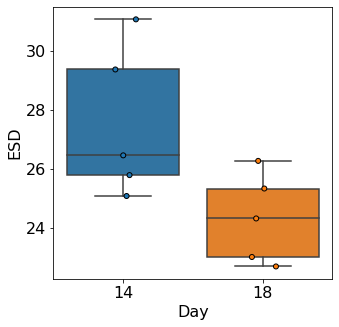

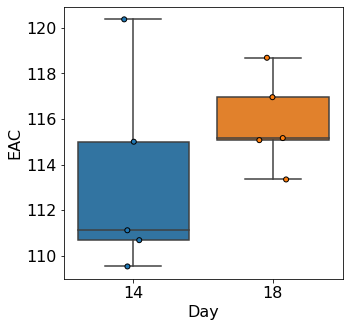

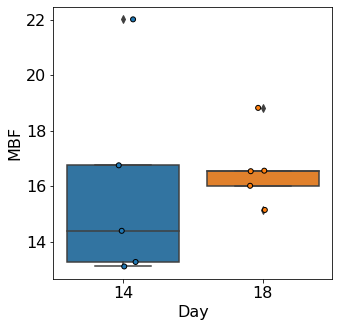

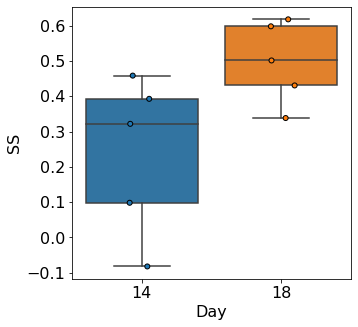

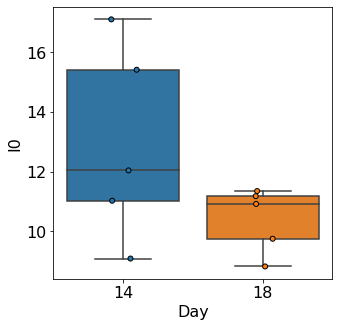

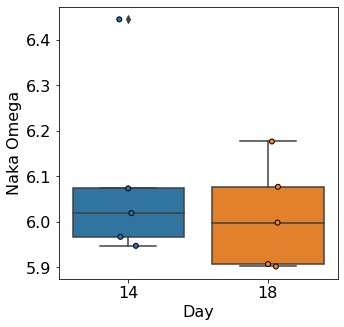

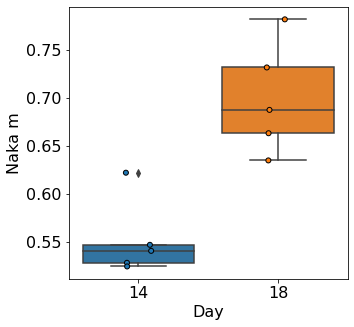

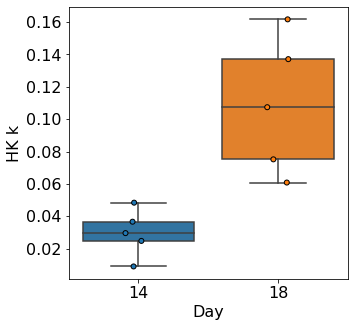

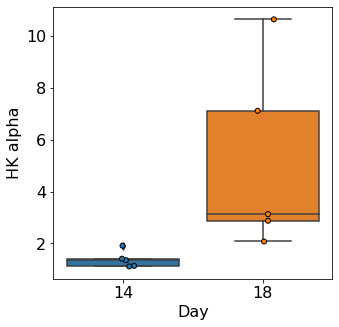

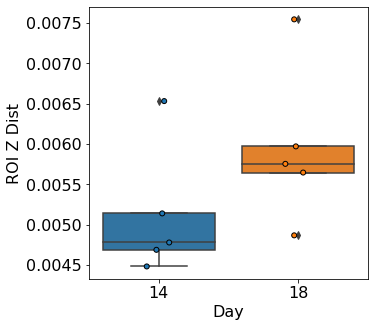

In [11]:
# Create box plots (with strip plot overlays) comparing the QUS parameters at days 14 and 18
d14_df = mean_data[mean_data['Day'] == 14]
d18_df = mean_data[mean_data['Day'] == 18]

for q_idx, q_param in enumerate(qus_params):
    this_fig, this_ax = plt.subplots(1,1,figsize=(5,5))

    sns.boxplot(data=mean_data,x='Day',y=q_param,ax=this_ax,palette='tab10')
    sns.stripplot(data=mean_data,x='Day',y=q_param,hue='Day',dodge=False,ax=this_ax,edgecolor='black',linewidth=1,palette='tab10')

    this_ax.set_xlabel(this_ax.get_xlabel(),fontsize=16)
    this_ax.set_ylabel(this_ax.get_ylabel(),fontsize=16)
    this_ax.legend([],[],frameon=False)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    save_str = f'_{q_param}_boxplot.tif'
    this_fig.savefig(save_str,bbox_inches='tight',dpi=200)

    